In [8]:
from re import findall
from time import time

import numpy as np
import numpy.testing as np_testing
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import load_iris
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import mean_squared_error, confusion_matrix as calculate_confusion_matrix
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from seaborn import heatmap

In [9]:
iris_data = load_iris()
X = iris_data.data
y = iris_data.target

print(f'Shape of samples {X.shape}')
print(f'Target names {iris_data.target_names}')

Shape of samples (150, 4)
Target names ['setosa' 'versicolor' 'virginica']


In [10]:
kmeans = KMeans(n_clusters=3,n_init=10, random_state=0)
kmeans.fit(X)

KMeans(n_clusters=3, n_init=10, random_state=0)

In [11]:
t0 = time()
estimator = KMeans(n_clusters=3, random_state=0, n_init = 10).fit(X)
fit_time = time() - t0
results = [fit_time, estimator.inertia_]

# define the metrics which require only the true labels and estimator labels
clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
]
results += [m(y, estimator.labels_) for m in clustering_metrics]

# the silhouette score requires the full dataset
results += [
        metrics.silhouette_score(
            X,
            estimator.labels_,
            metric="euclidean",
            sample_size=300,
    )
]

# show the results of each metric and print them
formatter_result = (
        "{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
)
print(66 * "_")
print("time\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
print(formatter_result.format(*results))
print(66 * "_")

__________________________________________________________________
time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
0.016s	79	0.751	0.765	0.758	0.730	0.755	0.553
__________________________________________________________________


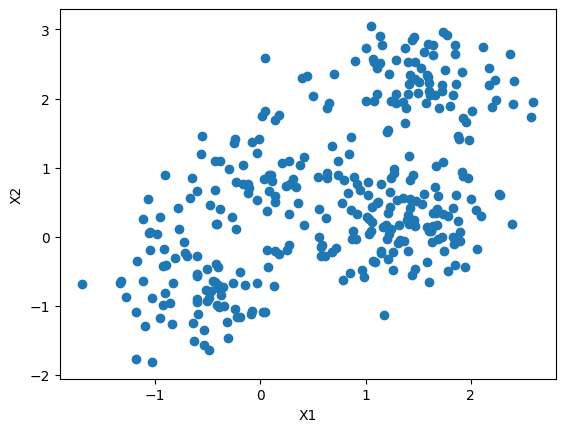

In [12]:
X = pd.read_csv('chooseK.csv').to_numpy()

plt.scatter(X[:,0],X[:,1])
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

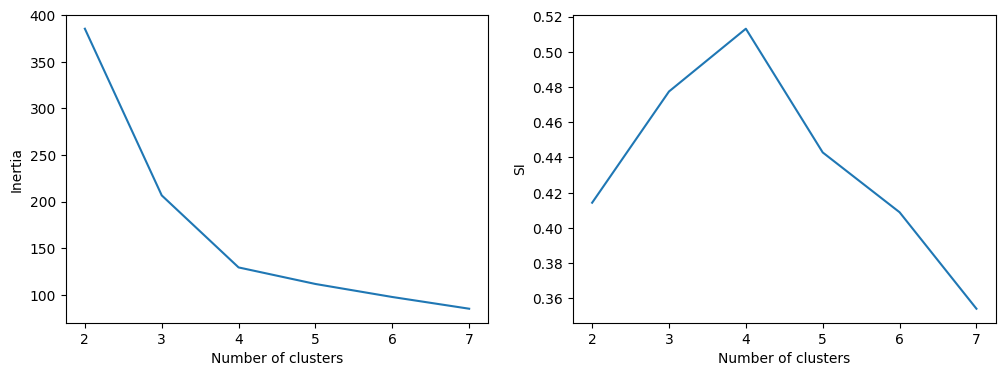

In [14]:
inertia = []
SI = []

from sklearn.metrics import silhouette_score
for k in range(2, 8):

    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(X)

    si = silhouette_score(X, kmeans.labels_)

    inertia.append(kmeans.inertia_)
    SI.append(si)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(np.arange(2,8),inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(np.arange(2,8))
plt.subplot(1,2,2)
plt.plot(np.arange(2,8),SI)
plt.xlabel('Number of clusters')
plt.ylabel('SI')
plt.xticks(np.arange(2,8))
plt.show()

**Here we can see from the above graphs that after 4 there are not much change in the inertia and therfore using the elbow method we can determine that 4 is the right amount of clusters**

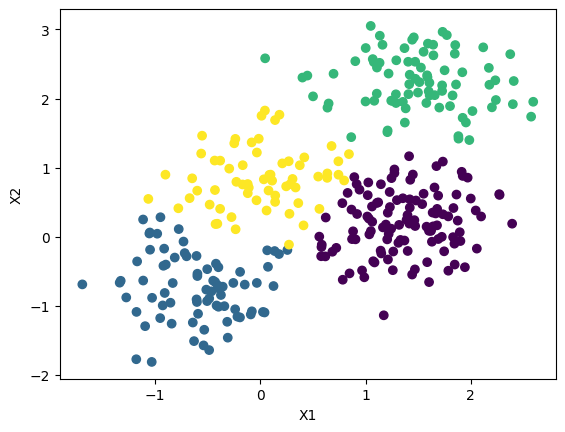

In [16]:
Best_k = 4

km=KMeans(n_clusters=Best_k, n_init=10).fit(X)
plt.scatter(X[:,0],X[:,1], c=km.labels_)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

# Bayes Theorem

In [19]:
comments = pd.read_csv('youtube_comments.csv')

training_comments = comments[len(comments) // 3:]
testing_comments = comments[:len(comments) // 3]

training_comments[:5]

,CONTENT,CLASS
551,Check out my YouTube channel I can rap﻿,1
552,I love your songs eminem your the rap god﻿,0
553,Subscribe to me and I'll subscribe back!!!﻿,1
554,I hav absolutely no idea what he's saying. Is ...,0
555,"I love this song, it´s for empowering every wo...",0


In [22]:
prior_spam_probability = len(training_comments.query('CLASS == 1')['CONTENT']) / len(training_comments)

def find_words(string):
    """Extracts alphanumeric words from a string into a list"""
    return findall("[a-z0-9äö']+", string)

def extract_frequencies(dataframe, column):
    """Extracts frequencies of words from the given column"""
    return dataframe[column].str.lower().apply(find_words).explode().value_counts()

spam_word_frequencies = extract_frequencies(training_comments.query('CLASS == 1'), 'CONTENT')
ham_word_frequencies = extract_frequencies(training_comments.query('CLASS == 0'), 'CONTENT')

In [23]:
print(f'Frequency of the word "love" in the spam comments: {spam_word_frequencies["love"]}')
print(f'Frequency of the word "love" in the ham comments": {ham_word_frequencies["love"]}')

Frequency of the word "love" in the spam comments: 22
Frequency of the word "love" in the ham comments": 93


In [24]:
def likelihood_spam(word):
    '''
    Parameter:
    word -- The word for which the likelihood is to be calculated

    Returns:
    Likelihood of the word given that the word is in a spam comment, should return
    1 if the word is not present in either spam or ham training data
    '''
    # If the word is present in both of the classes
    if word in spam_word_frequencies and word in ham_word_frequencies:

        return spam_word_frequencies[word] / spam_word_frequencies.sum()


    return 1

def likelihood_ham(word):
    '''
    Parameter:
    word -- The word for which the likelihood is to be calculated

    Returns:
    Likelihood of the word given that the word is in a ham comment, should return
    1 if the word is not present in either spam or ham training data
    '''
    if word in spam_word_frequencies and word in ham_word_frequencies:

        return ham_word_frequencies[word] / ham_word_frequencies.sum()

    return 1

In [32]:
def posterior_spam(comment):
    '''
    Parameter:
    comment -- String containing the comment for which the posterior probability is to be calculated

    Returns:
    Posterior probability of the comment being spam
    '''

    # Comment is forced into lower case and only unique alphanumeric words are extracted.
    # words = findall("[a-z0-9äö']+", comment.lower())
    # spam_probability_term = np.prod([likelihood_spam(word) for word in words]) * prior_spam_probability
    # ham_probability_term = np.prod([likelihood_ham(word) for word in words]) * (1 - prior_spam_probability)
    # return spam_probability_term / (spam_probability_term + ham_probability_term)


    words = findall("[a-z0-9äö']+", comment.lower())

    prior_spam = len(training_comments.query('CLASS == 1')) / len(training_comments)
    prior_ham = len(training_comments.query('CLASS == 0')) / len(training_comments)

    likelihood_spam_product = prior_spam
    likelihood_ham_product = prior_ham

    for word in words:
        likelihood_spam_product *= likelihood_spam(word)
        likelihood_ham_product *= likelihood_ham(word)

    if likelihood_spam_product + likelihood_ham_product == 0:
        return 0

    posterior_spam = likelihood_spam_product / (likelihood_spam_product + likelihood_ham_product)

    return posterior_spam


In [33]:
posterior_spam('This is a test sentence')

0.07971886960092503

In [34]:
predictions = np.array([posterior_spam(comment) for comment in testing_comments['CONTENT']])
discretized_predictions = predictions > 0.5

labels = testing_comments['CLASS']

In [35]:
accuracy = np.sum(discretized_predictions == labels) / len(testing_comments)

print(f"Classification accuracy: {accuracy}")

Classification accuracy: 0.9292196007259528


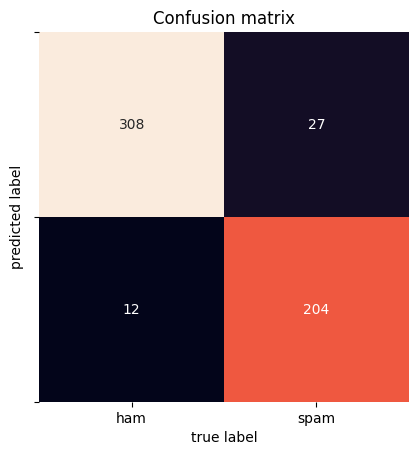

In [36]:
confusion_matrix = calculate_confusion_matrix(labels, discretized_predictions)
heatmap(
    confusion_matrix.T,
    square=True,
    annot=True,
    fmt='d',
    cbar=False,
    xticklabels=['ham', 'spam'],
    yticklabels=['ham', 'spam']
)
plt.yticks(range(3))
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('Confusion matrix')
plt.show()